In [2]:
from stride import Space, Time, Grid,Problem,PointTransducer,Shot,ScalarField,IsoAcousticDevito
import numpy as np
import time as timer
from scipy.io import savemat 
import asyncio

%matplotlib widget
async def run_simulation():
    cfl = 0.5
    dx  = 3.
    sos = 600.0
    time_span = 2.5
    dt = cfl * dx / sos
    t_num =int(time_span / dt) 
    grid_size = 400

    space = Space(
    shape=(grid_size, grid_size), extra=(50, 50), absorbing=(40, 40), spacing=dx
    )
    time = Time(
        start=0., step=dt , num=t_num
    )
    grid = Grid(space, time)

    problem = Problem(name='homo', space=space, time=time)
    problem.transducers.default()

    num_locations = grid_size ** 2

    # for i in range(num_locations):

    problem.geometry.default("elliptical", num_locations, radius = [0.3,0.3])
    receivers = problem.geometry.locations

    # offset = grid_size / 2 * dx
    center = grid_size * dx /2
    transducer_src = PointTransducer(id=0 , grid = grid)
    problem.geometry.add(id=num_locations, transducer=transducer_src, coordinates=[center, center])

    source = problem.geometry.locations[num_locations]

    shot = Shot(id=0,
                sources=[source], receivers=receivers,
                geometry=problem.geometry, problem=problem)
    problem.acquisitions.add(shot)

    f_centre = 0.5e6
    t = np.arange(0, time.num * time.step, time.step)
    delay = 0.4
    wave = (2*(np.pi * f_centre*(t-delay)))*np.exp(-(np.pi * f_centre*(t-delay))**2)

    shot.wavelets.data[0] = wave

    # data = np.full((grid_size, grid_size), 1500, dtype=int)

    # center = (grid_size /2 , grid_size /2)  # Center of the array
    # radius = 0.03 / dx # 3 cm radius
    # y, x = np.ogrid[:grid_size, :grid_size]
    # mask = (x - center[1])**2 + (y - center[0])**2 <= radius**2

    # data[mask] = 2000 #[m/s]
    # vp = ScalarField(name='vp', grid =problem.grid ,data = data)
    # problem.medium.add(vp)

    # data = np.full((grid_size, grid_size), 1000, dtype=int)
    # data[mask] = 1200 #[kg/m^3]

    # rho = ScalarField(name='rho', grid=problem.grid, data = data)
    # problem.medium.add(rho)

    
    center = grid_size * dx /2
    problem.geometry.locations[0].coordinates = np.array([center,center])
    sources = [problem.geometry.locations[0]]
    problem.plot()

    coordinates = [[rec.__get_desc__()['coordinates'][0] - offset, rec.__get_desc__()['coordinates'][1] - offset] for rec in receivers]
    
    coordinates_np = np.array(coordinates)

    data_dict = {
    'rec_pos': coordinates_np,
    'src_pos': coordinates_np,
    'input': wave,
    'cfl':cfl,
    'dx':dx,
    'dt':dt,
    'Nt':t_num
    }      
    return data_dict


In [1]:
import numpy as np
from scipy.io import savemat 

cfl = 0.5
dx  = 3.
sos = 600.0
time_span = 2.5
dt = cfl * dx / sos
Nt =int(time_span / dt) 
grid_size = 400

xz_scl = 600
sos = 600
xmin_spec = 0
xmax_spec = 1500 / xz_scl
zmin_spec = 0
zmax_spec = 1500 / xz_scl

n_abs = 3
nx = 100
dx = xmax_spec / nx
dz = zmax_spec / nx

xmin = xmin_spec + dx * n_abs
xmax = xmax_spec - dx * n_abs
zmin = zmin_spec + dz * n_abs
zmax = zmax_spec - dz * n_abs


f_centre = 3
t = np.arange(0, Nt * dt, dt)
delay = 0.4
wave = (2*(np.pi * f_centre*(t-delay)))*np.exp(-(np.pi * f_centre*(t-delay))**2)

x_0 = np.linspace(0, 1500, 500) / xz_scl
z_0 = np.linspace(0, 1500, 500) / xz_scl
x_0_mesh, z_0_mesh = np.meshgrid(x_0, z_0)
x_0 = x_0_mesh.reshape(-1, 1)
z_0 = z_0_mesh.reshape(-1, 1)
xz_0 = np.concatenate((x_0, z_0), axis=1)
print(xz_0.shape)
print(xz_0)

src_pos = np.array([xmax_spec/2 , zmax_spec /2])
print(src_pos)

data_dict = {
    'rec_pos': xz_0,
    'src_pos': src_pos,
    'input': wave,
    'cfl':cfl,
    'dx':dx,
    'dt':dt,
    'Nt':Nt
}      

mat_file = f"/home/stan/data/stride/stride_examples/tutorials/data/0815_homo_setting.mat"
savemat(mat_file, data_dict)

(250000, 2)
[[0.         0.        ]
 [0.00501002 0.        ]
 [0.01002004 0.        ]
 ...
 [2.48997996 2.5       ]
 [2.49498998 2.5       ]
 [2.5        2.5       ]]
[1.25 1.25]


In [5]:
import matplotlib.pyplot as plt

analy_sol  = np.load("/home/stan/data/pinn/data/0815_homo.npz")["data"]
print(analy_sol.shape)

(1000, 500, 500)


-0.07117858320423982


Text(0, 0.5, 'Y-axis')

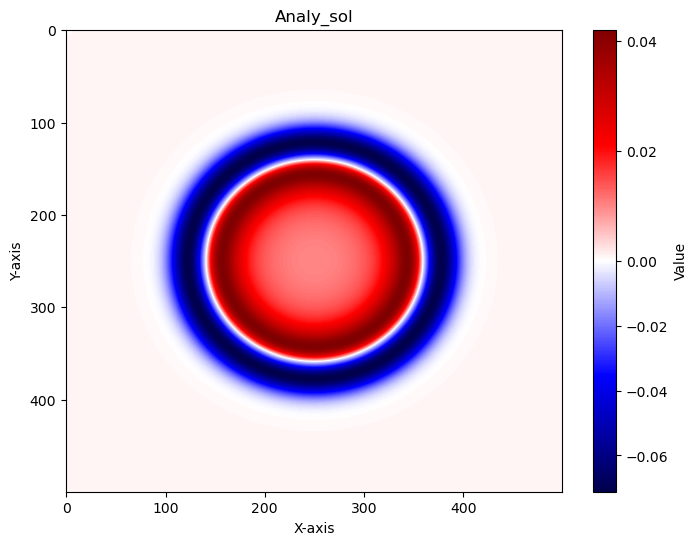

In [15]:
from matplotlib import colors
data = analy_sol[400]
print(np.min(data))
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("seismic")
# norm = colors.TwoSlopeNorm(vmin=np.min(data), vcenter=0, vmax=np.max(data))
norm = colors.TwoSlopeNorm(vmin=np.min(data), vcenter=0, vmax=np.max(data))
plt.imshow(data, cmap=cmap, norm=norm, aspect="auto")
plt.colorbar(label="Value")
plt.title(f"Analy_sol")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

In [4]:
# dx_scales = [2, 1, 2/3 ,0.5, 0.4]
dx_scales = [1]

# dx_scales = [1, 2/3]
# cfl_scales = [1 ,0.8, 0.6, 0.4, 0.2]
cfl_scales = [1 ,0.8 ,0.6,0.4, 0.2]
# cfl_scales = [0.8]

for dx_scale in dx_scales:
    for cfl_scale in cfl_scales:
        data = await run_simulation(dx_scale, cfl_scale)
        s = int (dx_scale * 10)
        c = int(cfl_scale * 10)
        mat_file = f"/home/stan/data/stride/stride_examples/tutorials/data/0815_homo_setting.mat"
        savemat(mat_file, data)
        # print(f"simulation dx_scale: {dx_scale}, cfl_scale: {cfl_scale} finished\n")